In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [29]:
import rebound
import numpy as np
import pandas as pd
import warnings
from multiprocessing import Process
import sys
from collections import OrderedDict
from multiprocessing import Pool
sys.path.insert(1, '..')
#print(path)
from SPOCKalt import *
sys.path.insert(1, '../SPOCKalt')
#Intigration/simsetup.py
from SPOCKalt import featureKlassifier
from SPOCKalt import simsetup
import plotFunctions

In [3]:
dataset = pd.read_csv('../modeldata/zfixed3brfill.csv')

In [4]:
initial = pd.read_csv('../modeldata/originalCondAllData.csv')

In [5]:
test = dataset.drop(dataset[dataset['prelimStable']==True].index)
test = test.drop(test[test['Stable']==False].index)

In [6]:
plot = dataset
plot = plot.drop(plot[plot['instability_time'] >1e6].index)


In [7]:
plot = plot.drop(plot[plot['threeBRfillfac']<18].index)
plot = plot.drop(plot[plot['Stable']==True].index)
#plot = plot.drop(plot[plot['index']==113762].index)
#param for 7inomolies

In [8]:
plot

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EMnear,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time
4,4,0.024455,0.423830,0.114561,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.029519,0.007250,0.018995,0.006777,0.011759,0.007401,True,False,87.918899,87.918899
6,6,0.022321,1.056435,0.559625,0.033683,0.047945,0.223957,0.060812,0.006313,0.013568,...,0.017209,0.012368,0.032865,0.014349,0.040884,0.027104,True,False,149.302780,149.302780
9,9,0.009580,4.796845,1.345806,0.009266,0.004422,0.281911,0.005430,0.000385,0.002968,...,0.021256,0.005527,0.009896,0.002450,0.014555,0.002293,True,False,105.724381,105.724381
12,12,0.024484,2.235458,0.486092,0.010436,0.006827,0.081604,2.005894,0.017435,0.008442,...,0.035979,0.009903,0.024957,0.013007,0.019479,0.018365,True,False,9.283792,9.283792
26,26,0.017160,0.245241,0.082569,0.003651,0.002833,0.333872,0.019425,0.000310,0.005618,...,0.008997,0.005086,0.019534,0.025497,0.024521,0.025353,True,False,406.304478,344.158495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137402,137402,0.027131,0.024008,0.020896,0.001604,0.000897,0.432967,0.001143,0.000146,0.000691,...,0.004269,0.010871,0.006388,0.010788,0.010379,0.010806,True,False,17282.818650,71332.537979
137717,137717,0.020504,0.016993,0.014592,0.000669,0.000135,0.260954,0.001262,0.000128,0.000360,...,0.002231,0.003346,0.003276,0.000481,0.004562,0.000473,True,False,38789.866734,57211.058460
137819,137819,0.018652,0.041402,0.029674,0.000217,0.000648,0.447997,0.000254,0.000139,0.000498,...,0.004972,0.001321,0.002405,0.000134,0.002579,0.000119,True,False,499429.402637,40388.203219
137833,137833,0.029221,0.036625,0.024067,0.000020,0.000451,0.087676,0.020955,0.019595,0.003407,...,0.006372,0.003889,0.005094,0.000603,0.001418,0.000490,True,False,13838.254568,8192.600320


62512
72620
75295
are they the same??

In [9]:
temp = dataset
temp['temp'] = dataset[['EMcrossnear', 'MMRstrengthnear','EMcrossfar','e1','e2','e3','m1','m2','m3','instability_time']].duplicated(keep = False)
#keep=False

In [10]:
temp = temp.drop(temp[temp['temp']==False].index)
# temp = temp.drop(temp[temp['temp']==True].index)
# MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd',
#            'MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
# scrambled = temp.sample(frac=1)
# scrambled = scrambled.reset_index()
# Nrows = int(0.8*scrambled.shape[0])
# train = scrambled.iloc[:Nrows, :]
# test = scrambled.iloc[Nrows:, :]
# resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

# testModel = XGBClassifier(learning_rate = 0.06, 
#                          max_depth = 40, 
#                          subsample = 0.95,
#                          min_child_weight = 4,
#                          n_estimators = 400,
#                          scale_pos_weight=resultBalance)

# testT = test.loc[test['Stable'] == True]
# testF = test.loc[test['Stable'] == False]

# tT = pd.concat([testT, testF.sample(n=7300)])
# tT = tT.sample(frac=1)

# testModel.fit(train[MMRDATA], train["Stable"])

In [11]:
# resPred = testModel.predict_proba(tT[MMRDATA])[:,1]

# print (metrics.roc_auc_score(tT['Stable'],resPred))
# #print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

In [12]:
temp

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,temp
34999,34999,0.048948,0.014947,0.011699,0.000111,0.000720,0.172004,0.003265,0.000312,0.000696,...,0.001614,0.003891,0.002285,0.001402,0.001065,True,False,1.321163e+06,9.929722e+05,True
35003,35003,0.059731,4.800682,0.007395,0.001899,0.001915,0.115272,0.010153,0.007811,0.001257,...,0.027158,0.050855,0.033664,0.049807,0.041267,True,False,1.096196e+05,2.411767e+05,True
35004,35004,0.092536,0.884034,0.040982,0.014742,0.014512,0.261001,0.006151,0.001399,0.005621,...,0.045506,0.016256,0.015721,0.065766,0.040640,True,False,5.073935e+06,3.751862e+06,True
35005,35005,0.065966,0.436618,0.025786,0.006401,0.006466,0.296618,0.019219,0.000221,0.002363,...,0.018521,0.024264,0.020696,0.019250,0.018949,True,False,2.642333e+06,2.111529e+06,True
35007,35007,0.203438,0.028219,0.003735,0.002194,0.000310,0.728547,0.002800,0.002201,0.003941,...,0.055201,0.110726,0.012549,0.064504,0.012906,True,False,7.052994e+04,1.388263e+05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138517,138517,0.076917,0.122667,0.011659,0.000425,0.001792,0.242232,0.006400,0.001182,0.004675,...,0.005001,0.002106,0.002105,0.006452,0.001984,True,False,9.250381e+04,2.470940e+04,True
138519,138519,0.183145,0.055947,0.013569,0.009941,0.015026,0.251661,1.797503,0.007928,0.007771,...,0.006799,0.082319,0.006222,0.091359,0.066802,True,False,9.720290e+07,6.887756e+07,True
138525,138525,0.095648,0.133675,0.089078,0.003447,0.006764,0.160328,8.359872,0.013267,0.010596,...,0.051901,0.117071,0.019928,0.062676,0.048736,True,False,1.743531e+04,4.305532e+03,True
138532,138532,0.251719,4.218909,0.047325,0.003907,0.000428,0.370925,0.075364,0.013615,0.011087,...,0.011347,0.222693,0.135751,0.042791,0.039253,True,False,2.838905e+05,1.394336e+05,True


In [14]:
temp.drop(temp[temp['EMcrossnear']!=temp.iloc[20,1]].index)

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,temp
35200,35200,0.075943,0.032309,0.020005,0.003739,0.003786,0.63486,0.01112,0.0,0.005062,...,0.007015,0.005197,0.000021,0.007045,0.002711,True,False,33576.012751,16402.832917,True
45646,45646,0.075943,0.032309,0.020005,0.003739,0.003786,0.63486,0.01112,0.0,0.005062,...,0.007015,0.005197,0.000021,0.007045,0.002711,True,False,33576.012751,16402.832917,True
55661,55661,0.075943,0.032309,0.020005,0.003739,0.003786,0.63486,0.01112,0.0,0.005062,...,0.007015,0.005197,0.000021,0.007045,0.002711,True,False,33576.012751,16402.832917,True


35200
45646
55661



[2.61946986637748⋅10 −6 , 0.00519962287759313, 0.00704526064124461]

In [191]:
def getRatL( Pratio: list,orderL):
    maxorder = max(orderL)
    delta = 0.03
    minperiodratio = Pratio-delta
    maxperiodratio = Pratio+delta # too many resonances close to 1
    if maxperiodratio >.999:
        maxperiodratio =.999
    res = plotFunctions.resonant_period_ratios(minperiodratio,maxperiodratio, order=maxorder)
    resList = [[]]*len(orderL)
    
    for each in res:
        resList[each[1]-each[0]-1] = resList[each[1]-each[0]-1]+[each]
    finals = []
    #print(resList)
    for eachO in resList:
        if len(eachO) !=0:
            val = [10000000,10]
            for i,each in enumerate(eachO):
                if np.abs((each[0]/each[1])-Pratio)<np.abs((val[0]/val[1])-Pratio):
                    val = each
            finals.append(val)
    return finals
    


In [204]:
def get_data(sim, Nint, Nout):
    '''gets dataframe '''
    times = np.linspace(0,Nint,Nout)
    data = pd.DataFrame()
    theta12 = np.zeros(Nout)
    theta23 = np.zeros(Nout)
    p2p1 = np.zeros(Nout)
    p3p2 = np.zeros(Nout)
    e1 = np.zeros(Nout)
    e2 = np.zeros(Nout)
    e3 = np.zeros(Nout)
    l1 = np.zeros(Nout)
    l2 = np.zeros(Nout)
    l3 = np.zeros(Nout)
    pomegarel12 = np.zeros(Nout)
    pomegarel23 = np.zeros(Nout)
    theta12 = np.zeros(Nout)
    theta23 = np.zeros(Nout)

    
    ps = sim.particles
    for i,each in enumerate(times):
        p2p1[i] = ((ps[2].P/ps[1].P))
        p3p2[i]=((ps[3].P/ps[2].P))
        e1[i]=(ps[1].e)
        e2[i]=(ps[2].e)
        e3[i]=(ps[3].e)
        l1[i]=(ps[1].l)
        l2[i]=(ps[2].l)
        l3[i]=(ps[3].l)
        pomegarel12[i]=(plotFunctions.getPomega(sim,1,2))
        pomegarel23[i]=(plotFunctions.getPomega(sim,2,3))

        sim.integrate(each, exact_finish_time=0)

    Pratio12 = 1/np.median(p2p1)
    Pratio23 = 1/np.median(p3p2)
    OrderL=[1,2,3,4,5]
    rat12 = getRatL(Pratio12,OrderL)
    thetalist12 = [[np.nan]*Nout]*len(rat12)
    #print(len(thetalist12[0]))
    for i,r in enumerate(rat12):
        for x in range(Nout):
                #
                # print(r)
                thetalist12[i][x]=plotFunctions.calcTheta(l1[x],l2[x],pomegarel12[x],r)
        #print(thetalist12[i])
        thetalist12[i]= np.unwrap(thetalist12[i])
    
    stds12 = list(map(np.std,thetalist12))
    which12 = stds12.index(min(stds12))
    theta12 = thetalist12[which12]
    pval12 = rat12[which12]
    

    rat23 = getRatL(Pratio23,OrderL)
    thetalist23 = [[np.nan]*Nout]*len(rat23)
    for i,r in enumerate(rat23):
        for x in range(Nout):
                thetalist23[i][x]=plotFunctions.calcTheta(l2[x],l3[x],pomegarel23[x],r)
        thetalist23[i]= np.unwrap(thetalist23[i])
    stds23 = list(map(np.std,thetalist23))
    which23 = stds23.index(min(stds23))
    theta23 = thetalist23[which23]
    pval23 = rat23[which23]
    
    
    
    
    #theta12 = np.mod(theta12,2*np.pi)
    #theta23 = np.mod(theta23,2*np.pi)
    print(np.std(theta12))
    print((np.std(theta23)))
    

    data=pd.DataFrame({'time':times,'p2/p1':p2p1,'p3/p2':p3p2,'theta12':theta12,'theta23':theta23,'e1':e1,'e2':e2,'e3':e3})
    return data,pval12,pval23

all exceptions have the same weirdly shaped theta23 plot as well as almost identical period ratio plots, main thing, increadbly compact outer pair

In [194]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
def get_plot(num,Nout=5000,Nint=100000):
    sim = simsetup.get_simList(initial.iloc[num,2:])
    simsetup.init_sim_parameters(sim)
    figure = plt.figure(figsize=[20,35])
    gs = GridSpec(4, 2, figure=figure)
    #gs.update(wspace = .1, hspace = .1)
    
    data, res12, res23 = get_data(sim,Nout,Nint)
    ax1 = plt.subplot(gs[0,0])
    ax1.set_title('threeBRfillfac:' +str(dataset['threeBRfillfac'][num]))
    data.plot.scatter(ax = ax1,x="p2/p1", y="p3/p2",s=2, c="time", colormap="copper", alpha=.35)
    ax2 = plt.subplot(gs[1,:2])
    ax2.set_title(str(res12[1])+':'+str(res12[0]))
    data.plot.scatter(ax=ax2,x="time", y="theta12",s=1)
    ax3 = plt.subplot(gs[2,:2])
    ax3.set_title(str(res23[1])+':'+str(res23[0]))
    data.plot.scatter(ax = ax3,x="time", y="theta23",s=1)
    ax4 = plt.subplot(gs[3,:2])
    data.plot(ax=ax4,x='time',y=['e1','e2','e3'])
    ax5 = plt.subplot(gs[0,1])
    ax5.set_title(str(num))
    ax5.set_aspect('equal')
    rebound.OrbitPlot(sim,fig=figure, ax=ax5,ylim=[-3,3],xlim=[-3,3])
    #plt.savefig(f'imgs/'+str(dataset['threeBRfillfac'][num])+'.png')
    #plt.show(False)

In [195]:
# sim = simsetup.get_simList(initial.iloc[25695,2:])
# simsetup.init_sim_parameters(sim)

# get_data(sim, 2, 3)

3933
9144
6571
16711
7135



12900

2905
#5373
129855

/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

75.79450638125579
0.003777213558476169


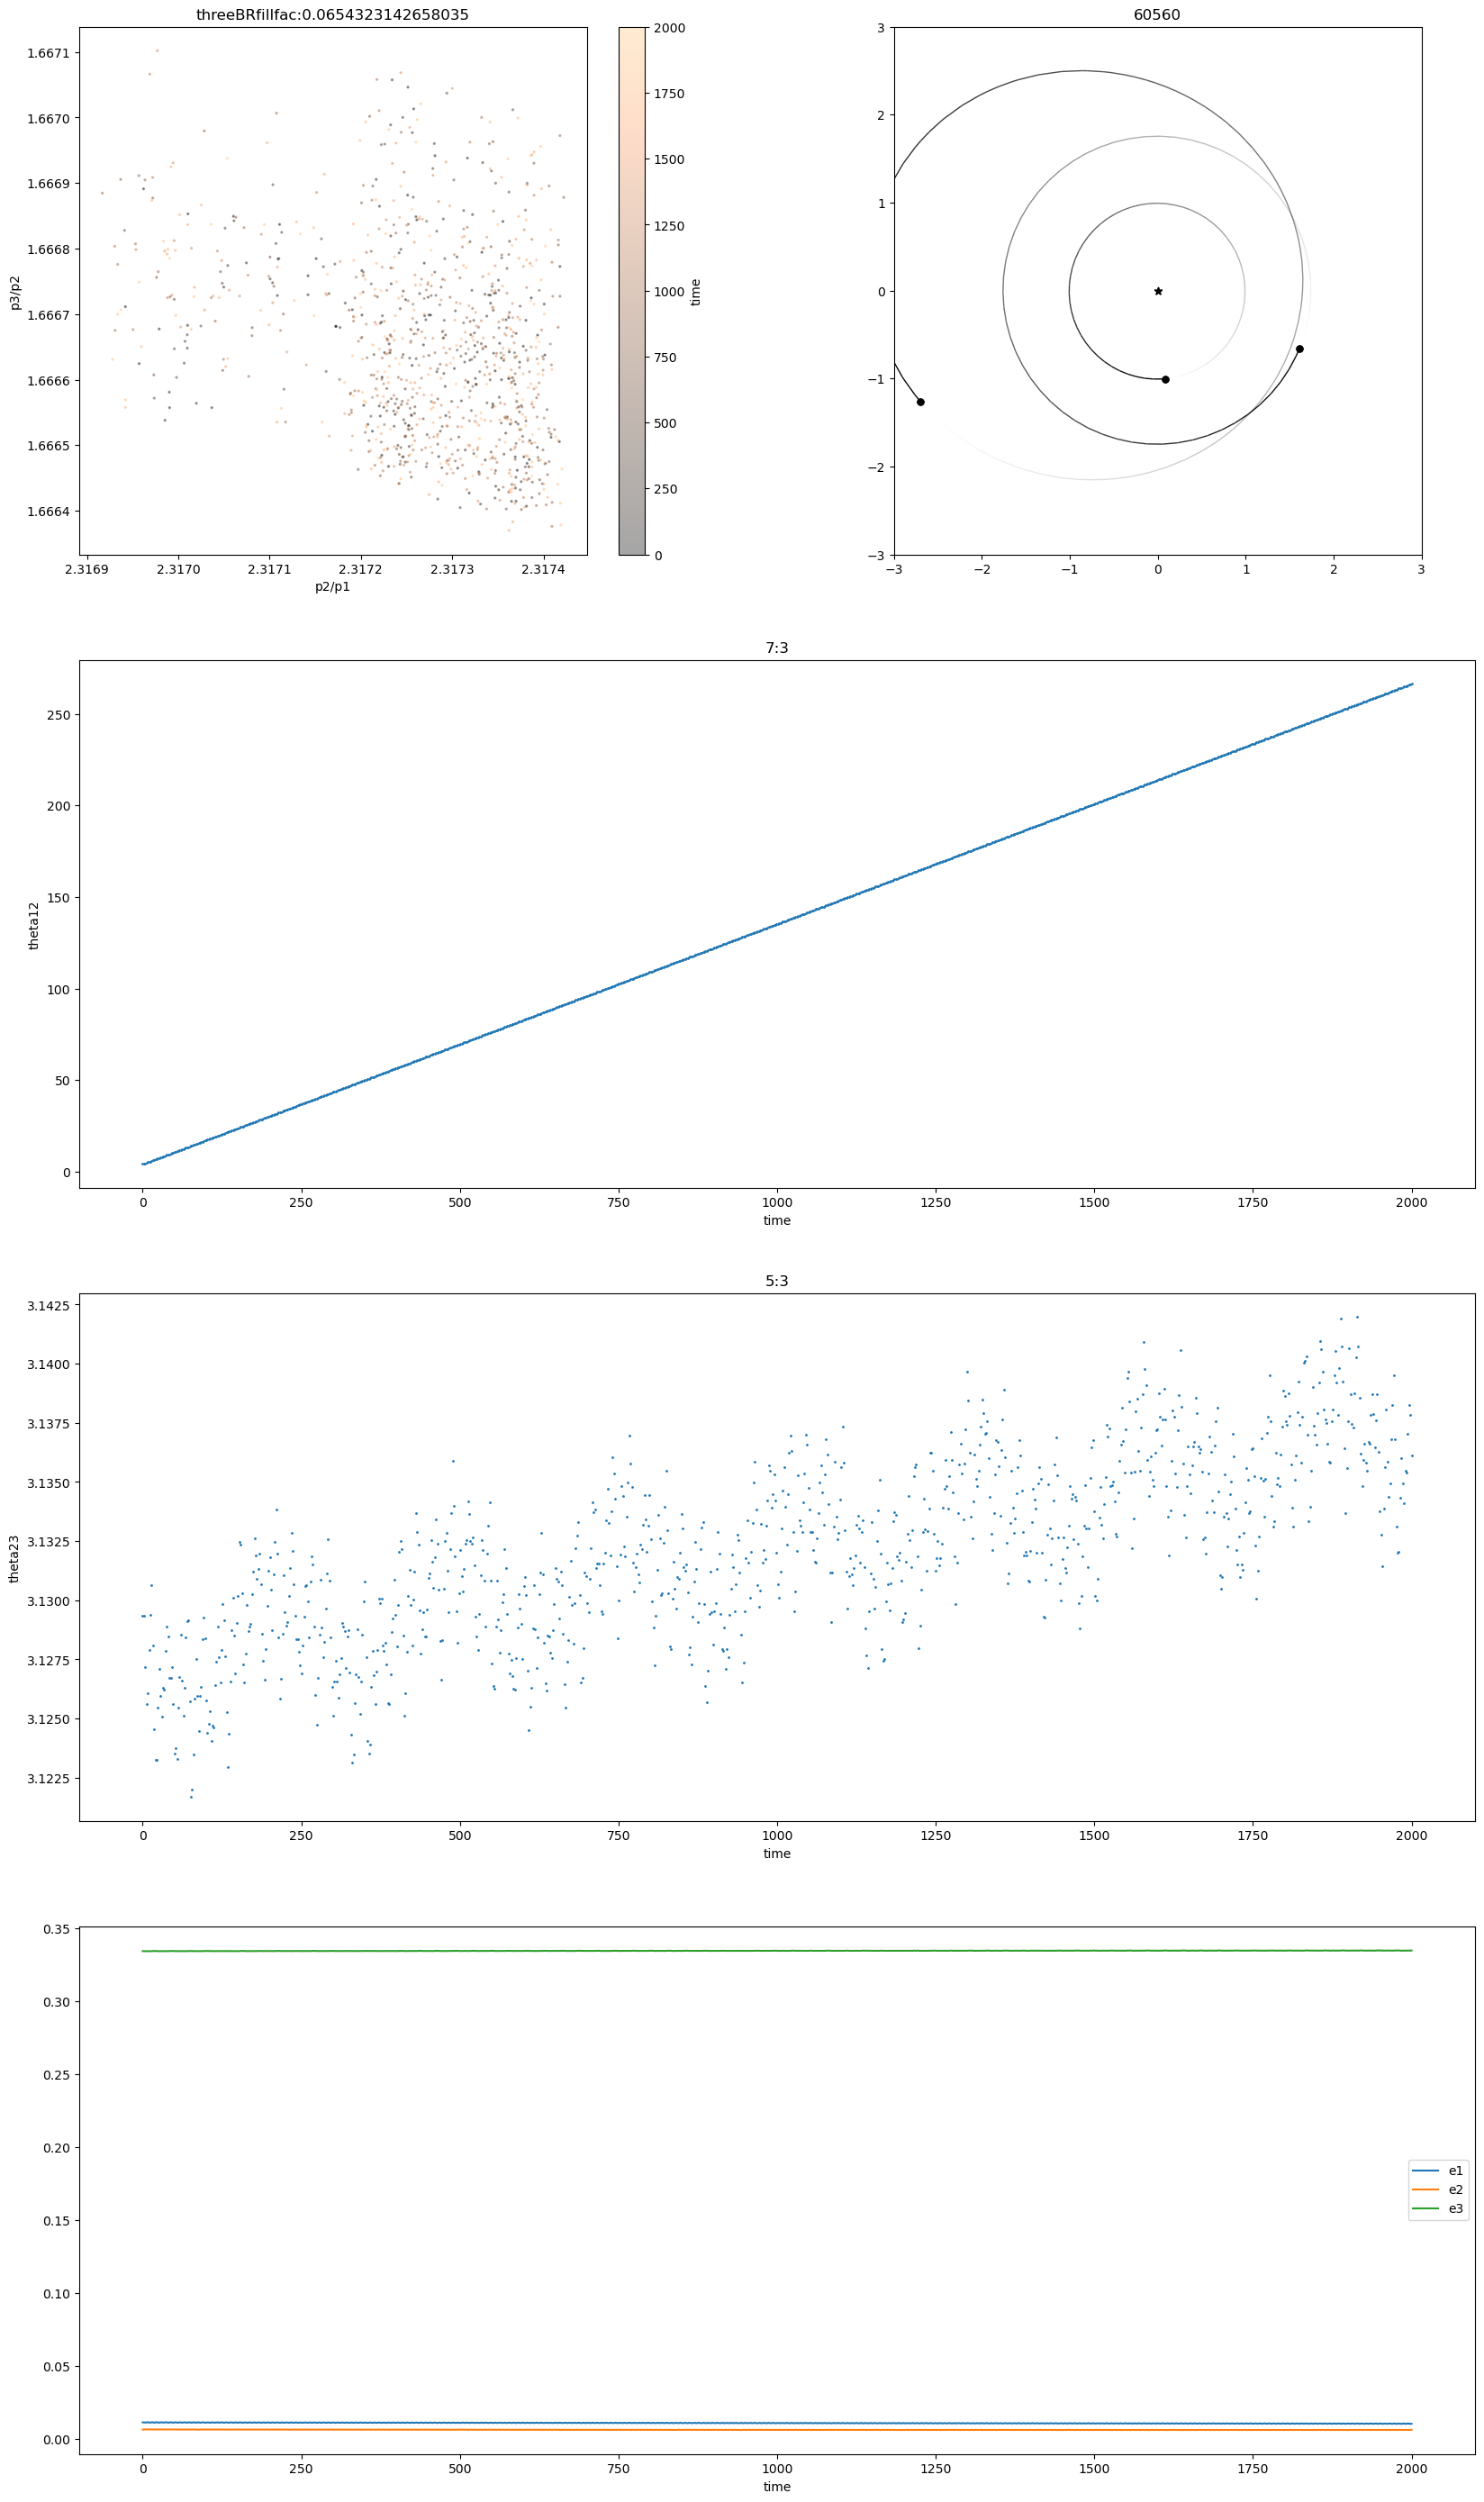

In [205]:
get_plot(60560,2000,1000)